In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')
from src.encode_data import *
from src.midi_data import *
# from src.data_sources import process_parallel, transform_csv_row
from src.midi_transform import *
from src.data_sources import process_all, arr2csv

In [3]:
from tqdm import tqdm

## Standardize and reformat raw midi files before encoding to text
- Transform key to C major
- Remove unused instruments
- Combine multiple tracks with the same instrument into a single part
- Melody, Piano, String

### Load midi data

In [4]:
version = 'v14'
data_path = Path('data/midi')
version_path = data_path/version

In [5]:
import pandas as pd

In [6]:
out_dir = 'piano_duet'
source_csv = version_path/out_dir/f'{out_dir}.csv'
source_csv.parent.mkdir(parents=True, exist_ok=True)
source_csv

PosixPath('data/midi/v14/piano_duet/piano_duet.csv')

In [7]:
num_comps = 2 # note, duration
cutoff = 4 # max instruments

In [8]:
df = pd.read_csv(source_csv); df.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,7,8,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,artist,ht_time_signature,ht_offset,song_url,midi,source,genres,section,midi_title,md5,ht_bpm,title,ht_mode,numpy,parts,ht_key,mxl
0,wayne-sharpe,4.0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,midi_sources/hooktheory/pianoroll/w/wayne-shar...,hooktheory,NaN,chorus,yu-gi-oh3,bf1f29e5ff84e3e93e37fb873bfb590e,128.0,yu-gi-oh-theme-song,1.0,piano_duet/hooktheory/pianoroll/w/wayne-sharpe...,"intro,chorus",C,NaN
1,wayne-sharpe,3.0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,midi_sources/hooktheory/pianoroll/w/wayne-shar...,hooktheory,NaN,intro,yu-gi-oh,055f80ad67f64edb14a85ca8fbfe8c29,85.0,yu-gi-oh-theme-song,1.0,piano_duet/hooktheory/pianoroll/w/wayne-sharpe...,"intro,chorus",C,NaN
2,what-a-day,4.0,-5.0,https://www.hooktheory.com/theorytab/view/what...,midi_sources/hooktheory/pianoroll/w/what-a-day...,hooktheory,Jazz,chorus,kiefer,197f96f5d181f6ce1e2c5ab04ac1ff87,96.0,kiefer,6.0,piano_duet/hooktheory/pianoroll/w/what-a-day/k...,chorus,D,NaN
3,whiteflame,4.0,-5.0,https://www.hooktheory.com/theorytab/view/whit...,midi_sources/hooktheory/pianoroll/w/whiteflame...,hooktheory,"J-Pop,Pop",pre-chorus,senbonzakura - pre-Pre-Chorus,9e7ce13a35f1314423a9a6d5a5287a4a,152.0,senbonzakura,6.0,piano_duet/hooktheory/pianoroll/w/whiteflame/s...,"verse,pre-chorus,chorus",D,NaN
4,whiteflame,4.0,-5.0,https://www.hooktheory.com/theorytab/view/whit...,midi_sources/hooktheory/pianoroll/w/whiteflame...,hooktheory,"J-Pop,Pop",verse,Senbonzakura,d5aaf79d0989222f1362f9f46c540a27,152.0,senbonzakura,6.0,piano_duet/hooktheory/pianoroll/w/whiteflame/s...,"verse,pre-chorus,chorus",D,NaN


In [9]:
ecomp_records = df.loc[df.source == 'ecomp'].to_dict(orient='records')

In [10]:
all_records = df.to_dict(orient='records')

### Need better midi formatting

In [11]:
old_sep = -2
old_eoff = 3

In [12]:
from src.fastai_data import *
vocab = MusicVocab.create()

In [13]:
def transform_func(metadata):
    input_path = version_path/'old'/metadata['numpy']
    output_path = version_path/metadata['numpy']
#     if not input_path.exists(): return
#     if output_path.exists(): return
    output_path.parent.mkdir(parents=True, exist_ok=True)
    np_array = np.load(input_path)[1:] - old_eoff
    np_array[np_array[:,0] == old_sep, 0] = VALTSEP
    np.save(output_path, np_array)
#     print(output_path)

In [14]:
# # sanity check
# import random
# for r in random.sample(ecomp_records, 500):
#     transform_func(r)
        

In [15]:
processed = process_all(transform_func, all_records)

In [15]:
### AS TOD: Fix 'info channel is not channel 0' error

In [16]:
# all_records = all_records[60000:]

## Sanity check

In [17]:
m1 = all_records[0]

In [18]:
transform_func(m1)

In [19]:
tfm_arr = np.load(version_path/m1['numpy']); tfm_arr

array([[-1,  2],
       [55,  1],
       [-1,  1],
       [54,  1],
       ...,
       [-1,  8],
       [58, 16],
       [54, 16],
       [51, 16]])

In [20]:
test = np.load(version_path/'old'/m1['numpy']); test

array([[  2, 132],
       [  1,   5],
       [ 58,   4],
       [  1,   4],
       ...,
       [  1,  11],
       [ 61,  19],
       [ 57,  19],
       [ 54,  19]])

In [21]:
s = npenc2stream(tfm_arr)

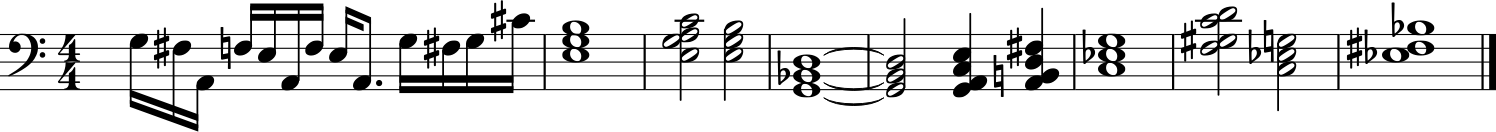

In [22]:
s.show()

In [23]:
s.show('midi')

In [39]:
to_double_stream(to_single_stream(tfm_arr, vocab), vocab)

array([[  -8, -138],
       [  -1,    2],
       [  55,    1],
       [  -1,    1],
       ...,
       [  -1,    8],
       [  58,   16],
       [  54,   16],
       [  51,   16]])

In [42]:
(tfm_arr == to_double_stream(to_single_stream(tfm_arr, vocab), vocab)[1:]).all()

True

## Compare wtih original transform

In [29]:
def transform_midi(midi_file):
    input_path = midi_file
    
#     if duet_only:
#         try: 
#             if num_piano_tracks(input_path) not in [1, 2] : return None
#         except Exception: return None
    
    try: input_file = compress_midi_file(input_path, cutoff=cutoff) # remove non note tracks and standardize instruments
    except music21.midi.MidiException as e:
        print('Error parsing midi', input_path, e)
        return None
    if not input_file: return None
        
    # Part 2. Compress rests and long notes
    stream = file2stream(input_file) # 1.
    try:
        chordarr = stream2chordarr(stream, max_dur=DURATION_RANGE-2, flat=False) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
    except Exception as e:
        print('Could not encode to chordarr:', input_path, e)
        print(traceback.format_exc())
        return None
    
    chord_trim = trim_chordarr_rests(chordarr)
    chord_short = shorten_chordarr_rests(chord_trim)
    delta_trim = chord_trim.shape[0] - chord_short.shape[0]
    if delta_trim > 300: 
        print(f'Removed {delta_trim} rests from {input_path}. Skipping song')
        return None
    chordarr = chord_short
    
    # Part 3. Chord array to numpy
    seq = chordarr2seq(chordarr)
    if len(seq) < 32:
        print('Sequence too short:', len(seq), input_path)
        return None
    
    npenc = seq2npenc(seq)
    if (npenc[:,1] >= DURATION_RANGE).any(): 
        print('npenc exceeds max 128 duration:', input_path)
        return None
    
    # https://en.wikipedia.org/wiki/Scientific_pitch_notation - 88 key range - 21 = A0, 108 = C8
    if ((npenc[...,0] > VALTSEP) & ((npenc[...,0] < PIANO_RANGE[0]) | (npenc[...,0] >= PIANO_RANGE[1]))).any(): 
        print('npenc out of piano note range 12 - 116:', input_path)
        return None
    
    return npenc

In [30]:
path = version_path/m1['midi']

In [31]:
out = transform_midi(path)

In [32]:
out

array([[-1,  2],
       [55,  1],
       [-1,  1],
       [54,  1],
       ...,
       [-1,  8],
       [58, 16],
       [54, 16],
       [51, 16]])

In [33]:
(tfm_arr == out).all()

True